In [1]:
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Flatten, Conv2D
from keras.models import Model
from keras.regularizers import l1
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os, sys
import h5py
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
sys.path.insert(0,'../lib')

Using TensorFlow backend.


In [2]:
f = h5py.File('../processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth.z', 'r')
treeArray = f['t_allpar_new'][()]

features = ['j1_etarot', 'j1_phirot', 'j1_ptrel', 'j_index']
labels = ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index']

features_labels_df = pd.DataFrame(treeArray,columns=list(set(features+labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_df = features_labels_df[features]
labels_df = features_labels_df[labels]

labels_df = labels_df.drop_duplicates()

# Convert to numpy array 
features_val = features_df.values
labels_val = labels_df.values    

if 'j_index' in features:
    features_val = features_val[:,:-1] # drop the j_index feature
if 'j_index' in labels:
    labels_val = labels_val[:,:-1] # drop the j_index label
    print(labels_val.shape)

(24816, 5)


In [3]:
BinsX = 40
BinsY = 40
MinX = -0.8
MaxX = 0.8
MinY = -1.0
MaxY = 1.0
features_2dval = np.zeros((len(labels_df), BinsX, BinsY, 1))
for i in range(0, len(labels_df)):
    features_df_i = features_df[features_df['j_index']==labels_df['j_index'].iloc[i]]
    index_values = features_df_i.index.values

    xbins = np.linspace(MinX,MaxX,BinsX+1)
    ybins = np.linspace(MinY,MaxY,BinsY+1)

    x = features_df_i[features[0]]           
    y = features_df_i[features[1]]
    w = features_df_i[features[2]]

    hist, xedges, yedges = np.histogram2d(x, y, weights=w, bins=(xbins,ybins))

    for ix in range(0,BinsX):
        for iy in range(0,BinsY):
            features_2dval[i,ix,iy,0] = hist[ix,iy]
features_val = features_2dval

In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features_val, labels_val, test_size=0.2, random_state=42)

In [5]:
if 'j_index' in labels:
    labels = labels[:-1]

In [6]:
Inputs = Input(shape=(40, 40, 1,))
x = Conv2D(filters=8, kernel_size=(11,11), strides=(1,1), padding='same',
           kernel_initializer='he_normal', use_bias=True, name='conv1_relu',
           activation = 'relu')(Inputs)
x = Conv2D(filters=4, kernel_size=(3,3), strides=(2,2), padding='same',
           kernel_initializer='he_normal', use_bias=True, name='conv2_relu',
           activation = 'relu')(x)
x = Conv2D(filters=2, kernel_size=(3,3), strides=(2,2), padding='same',
           kernel_initializer='he_normal', use_bias=True, name='conv3_relu',
           activation = 'relu')(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(5, activation='softmax', kernel_initializer='lecun_uniform', name='output_softmax')(x)
model = Model(inputs=Inputs, outputs=predictions)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 40, 1)]       0         
_________________________________________________________________
conv1_relu (Conv2D)          (None, 40, 40, 8)         976       
_________________________________________________________________
conv2_relu (Conv2D)          (None, 20, 20, 4)         292       
_________________________________________________________________
conv3_relu (Conv2D)          (None, 10, 10, 2)         74        
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                6432      
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 165   

In [7]:
adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 100,
                    validation_split = 0.25, shuffle = True, callbacks = None, 
                    use_multiprocessing=True, workers=4)

Epoch 1/100
15/15 [==============================] - 1s 39ms/step - loss: 1.6067 - accuracy: 0.1770 - val_loss: 1.6031 - val_accuracy: 0.3415
Epoch 2/100
15/15 [==============================] - 0s 17ms/step - loss: 1.5983 - accuracy: 0.6103 - val_loss: 1.5938 - val_accuracy: 0.8803
Epoch 3/100
15/15 [==============================] - 0s 17ms/step - loss: 1.5875 - accuracy: 0.8998 - val_loss: 1.5802 - val_accuracy: 0.8964
Epoch 4/100
15/15 [==============================] - 0s 17ms/step - loss: 1.5702 - accuracy: 0.9009 - val_loss: 1.5574 - val_accuracy: 0.8962
Epoch 5/100
15/15 [==============================] - 0s 17ms/step - loss: 1.5427 - accuracy: 0.9005 - val_loss: 1.5235 - val_accuracy: 0.8964
Epoch 6/100
15/15 [==============================] - 0s 15ms/step - loss: 1.5040 - accuracy: 0.8999 - val_loss: 1.4782 - val_accuracy: 0.8904
Epoch 7/100
15/15 [==============================] - 0s 16ms/step - loss: 1.4532 - accuracy: 0.8912 - val_loss: 1.4201 - val_accuracy: 0.8777
Epoch 

15/15 [==============================] - 0s 17ms/step - loss: 0.0187 - accuracy: 0.9997 - val_loss: 0.0204 - val_accuracy: 0.9996
Epoch 59/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0178 - accuracy: 0.9997 - val_loss: 0.0195 - val_accuracy: 0.9996
Epoch 60/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0169 - accuracy: 0.9997 - val_loss: 0.0187 - val_accuracy: 0.9996
Epoch 61/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0161 - accuracy: 0.9997 - val_loss: 0.0180 - val_accuracy: 0.9996
Epoch 62/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0154 - accuracy: 0.9997 - val_loss: 0.0173 - val_accuracy: 0.9996
Epoch 63/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0147 - accuracy: 0.9997 - val_loss: 0.0166 - val_accuracy: 0.9996
Epoch 64/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0140 - accuracy: 0.9997 - val_loss: 0.0160 - val_accuracy: 0.9996
Epoch 65/100

In [9]:
model.save('Conv2D') #Saves to local directory;

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Conv2D\assets


In [10]:
loaded_model = keras.models.load_model('Conv2D') #Loads from local directory

In [11]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 40, 1)]       0         
_________________________________________________________________
conv1_relu (Conv2D)          (None, 40, 40, 8)         976       
_________________________________________________________________
conv2_relu (Conv2D)          (None, 20, 20, 4)         292       
_________________________________________________________________
conv3_relu (Conv2D)          (None, 10, 10, 2)         74        
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                6432      
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 165   

In [12]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    #plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

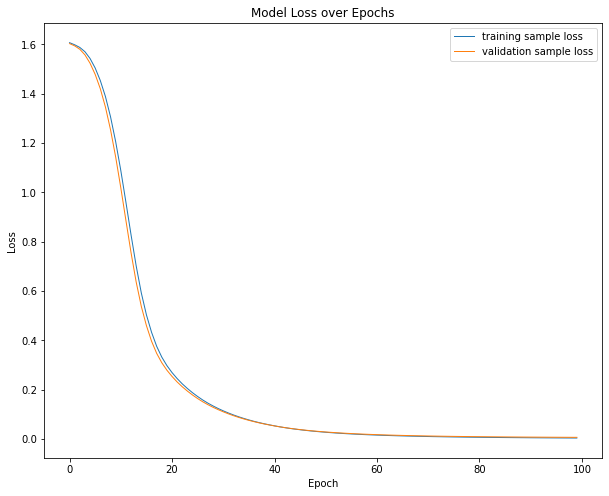

In [13]:
learningCurve(history)

In [14]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'CONV2D ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

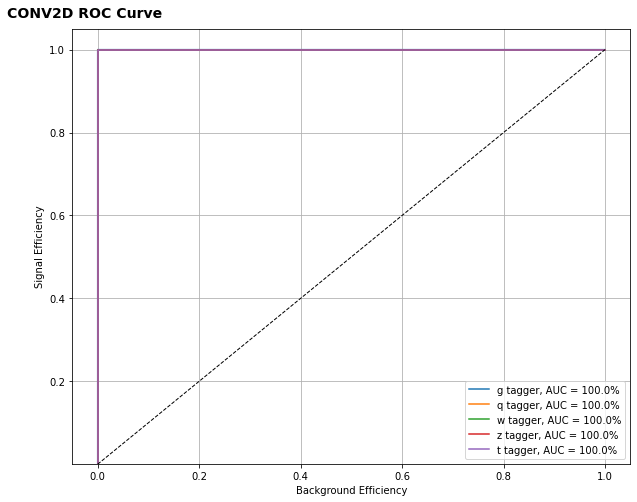

In [15]:
y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='Conv2D')